# PCA: Свой jpeg с блекджеком  и куртизантками

<img src='https://cs.pikabu.ru/post_img/2013/08/07/10/1375893075_408844834.jpg' width=400>

### 1. Как работает jpeg: в двух словах

Все изображение делится на квадраты 8х8 а затем каждый кусочек представляется в виде суммы из базисных кусочков 
(базисных векторов фурье-преобразования). 
Выбор именно такого базиса обусловлен универсальностью, но не обязательно наиболее выгоден для того или иного изображения. 

Выглядят базисные вектора jpeg вот так:
<img src='https://upload.wikimedia.org/wikipedia/commons/2/24/DCT-8x8.png' width=300>

Для тех кто хочет подробнее https://habrahabr.ru/post/206264/

(На самом деле там есть еще несколько этапов но нас интересует именно разложение в базис)

### 2. Задание
В качестве интересного способа практического применения PCA предлагаю вам сделать разложение на вектора, оптимальные для конкретного изображения (или набора изображений). Эти вектора мы можем легко получить, воспользовавшись SVD разложением.

Схема следующая:

Входные параметры - размер кусочков $n$ количество базисных векторов $d$
1. Разбиваем изображение на кусочки $n\times n$. всего получим $q=\frac{width*height}{n^2}$ кусочков
2. К каждому кусочку применяем `np.array.flatten()`. В итогe получаем матрицу $X$ размера $n^2\times q$
3. Делаем PCA, оставляем только $d$ компонент с наибольшими собственными значениями, получаем матрицу $d \times q$.(см код семинара)
4. Получившиеся вектора размера d переводим обратно в пространство размерности $n^2$ (см. код семинара)
5. применяем `numpy.reshape((n,n))`, cклеиваем кусочки обратно в том же порядке, что и разбивали
6. Выводим картинку и наслаждаемся результатом.
6. Визуализируем базисные вектора и сравниваем с джипеговскими (функция для визуализации прилагается)

Во время выполнения задания следите за размерностями матриц, чтоб избежать ошибок

### 3. Эксперименты
1. Посмотреть как меняется энтропия изображения и какая степень сжатия
2. Найти оптимальный размер $n$ и количество векторов $d$ 
3. Сравнить такой способ сжатия с <a href="https://docs.python.org/2/library/jpeg.html">jpeg</a>
4. Вычесть из исходного изображения сжатое, чтоб посмотреть какие пиксели отличаются.


### 4. Идеи для дальнейшего развития
1. Что если делить на маленькие квадраты, сжимать их не очень сильно, а получившиеся вектора меньшей размерности соединять в "большие квадраты" и к ним еще раз применять PCA (а потом еще раз и еще раз)?
2. Что если в случае маленькой дисперсии объединять квадраты в один и раскладывать в базис уже его?
3. Что если сделать параметром не количество базисных векторов а пороговую дисперсию? Иными словами - выбирать $d$ в зависимости от дисперии кусочка.
4. Что если сверточные сети обучать на таком представлении (матрица $d \times q$)?

Если возникли какие-то сложности пишите мне http://t.me/danlkv http://vk.com/danilozzz

Если получилось реализовать что-то из идей тоже пишите, мне самому очень интересно что будет.

Успехов!

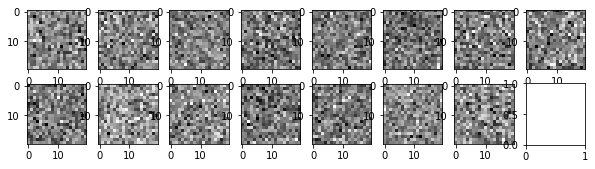

In [87]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images_table(imgs, columns=8):
    n=len(imgs) # здесь imgs -  массив из 15 элементов 20*20 ( для tt)
    h = (n-1)//columns+1 # вычисляем минимальную нужную высоту
    f,ax=plt.subplots(h,columns,figsize=(10,10*h/columns)) # первая циферка- сколько вмещается по OY, вторая- по OX, размер - кол-во пространства, отводимого по OX и по OY
    for i in range(1,n+1):
        ax[(i-1)//columns,i%columns-1].imshow(imgs[i-1],cmap='gray') # каждой картинке сопостовляем изображения из массива
tt = np.random.randn(15,20,20)
plot_images_table(tt)
plt.show()

In [88]:
import requests
from PIL import Image
from io import BytesIO
# функция скачивает изображение по ссылке
def get_image(url): # с семинара - возвращает изображение
    print("making request")
    r = requests.get(url)
    strio = BytesIO(r.content)
    i = Image.open(strio)
    print("got image with size %s"%str(np.array(i).shape))
    return i

In [89]:
# Эту функцию можно очень просто модифицировать для идеи #3
def pca(X,num_components):
    lka=[l.mean() for l in X]
    X=np.array([l-np.mean(l) for l in X]) # Вычитаем среднее
    U,s,V=np.linalg.svd(X)                # Находим собственные вектора
    eps=np.sort(s)[-num_components]       # пороговое собственное значение (служебная строчка) 
    E = np.array([vec for val,vec in zip(s,V)
                  if val>eps])            # берем только важные вектора   (с большими собственными значениями)
    X_=np.dot(E,X.T).T# Преобразуем данные
    return X_,E, np.array(lka)

In [90]:
#П.1: Получаем изображение, разбиваем на кусочки
#url='https://storage.googleapis.com/multi-static-content/previews/artage-io-thumb-1cde60028faa652e1242639e6a6d2f1f.png' # Ну или какое-то другое
url='https://hsto.org/getpro/habr/post_images/a78/291/807/a7829180746c99c987384e4b2b6df7b8.png'
image=get_image(url)
img=np.array(image)
n=8
strok=len(img)
stolb=len(img[0])
def r(img,n, strok, stolb): # ф-я разбиения на кусочки
    bits=[]
    for i in range(strok//n): #строки
        for j in range(stolb//n): #столбцы
            bit=img[i*n:i*n+n,j*n:j*n+n ]
            bits.append(bit)
    return np.array(bits)
            
            
            
vec=r(img, n, strok, stolb)
# Разибили на такие вот кусочки и запихали всё это в одномерный массив(здесь - 1024 элемента по 8*8*4 (4= rgba))

making request
got image with size (256, 256)


In [91]:
def rer2(bits, n, strok, stolb):
    img=[np.array([0 for i in range(stolb)]) for i in range(strok)]
    for i in range(strok):
        for j in range(stolb):
            #bits_strok=i//n     bits_stolb=j//n
            img[i][j]=bits[(i//n)*(strok//n) + j//n ][i%n][j%n]
    return np.array(img)
            

In [92]:
#П2:
vectors=[]
for i in range(len(vec)):
    vectors.append(vec[i].flatten())
vectors=np.array(vectors)
vectors.shape

(1024, 64)

In [93]:
# Готовим матрицу объекторв, делаем PCA
d=10
newvec, E, lka=pca(vectors, d)
reconstr = np.dot(newvec,E)
for i in range(len(reconstr)):
    reconstr[i]+=lka[i]

In [94]:
# Переводим закодированные кусочки обратно в пространство где они имеют смысл изображения
reconstr2=[]
for i in range(len(reconstr)):
    reconstr2.append(reconstr[i].reshape(n, n))
reconstr2=np.array(reconstr2)
reconstr2.shape

(1024, 8, 8)

In [95]:
reconstr3=rer2(reconstr2, n, strok, stolb)  

#print(type(reconstr3[1][1]), type(reconstr4[1][1]))


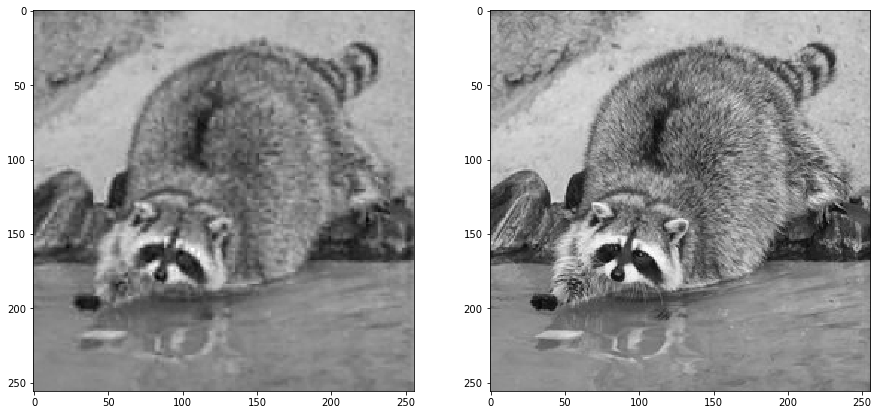

In [96]:
# Выводим картинку
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(reconstr3,cmap='gray')
plt.subplot(122)
plt.imshow(img,cmap='gray')
plt.show()

**Небольшой минивывод: уменьшение n или увеличение d повышают качество картинки( очевидно, либо картинка разбивается на меньшие
                                                                                куски, и качество выше, либо
                                                                                мы увеличиваем кол-во важных "осей", что, опять же, повышает качетство.**

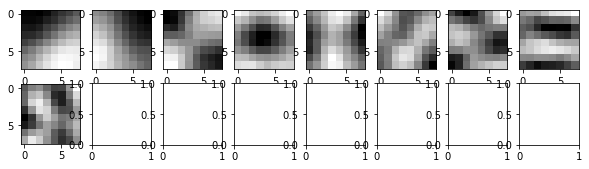

In [97]:
# Выводим базисные вектора
E2=[]
for i in range(len(E)):
    E2.append(E[i].reshape(n,n))
E2=np.array(E2)
plot_images_table(E2)
plt.show()

** Примеание: ф-я plot_images_table не будет работать для d<=9, т.к. ax будет одномерным массивом, а ожидается двухмерный.**

** На мой взгляд, в сравнении с jpeg такие векторы выглядят менее однородными. Т.е. они не поделены на какие-то чёткие зоны( квадратики).
Мне кажется, что это хорошо, ведь, если нет такого разделения, то получается, что эти векторы как бы более точны, для каждой точечки
выходят лучшие измерения.**

In [61]:
# Эксперименты

In [ ]:
#EX1: 

In [122]:
def ent(img):
    #ожидается массив a*b, где в каждом img[ai][bj]- значение цвета пикселя
    # Находим количество всех символов
    count=np.array([0 for i in range(1000)]) # делаю с запасом, т.к.
    for i in range(len(img)):
        for j in range(len(img[0])):
            count[img[i][j]]+=1
    # убираем невстерчающиеся символы ( дабы не было деления на 0 в формуле Шеннона)
    count = count[count!=0] 
    # sum(count) --> 256*256=65535, лекго убедиться
    #теперь найдём вероятность появления каждого символа
    ver=count/(len(img)*len(img[0]))
    # sum(ver)=1, в этом легко убедиться
    # Вычисляем энтропию: она равна summ(pi*log(2)(1/pi))
    entropia=0
    for i in ver:
        entropia += i*np.log2(1/i)
    return entropia
print(ent(img))
print(ent(reconstr3))
print((ent(img)-ent(reconstr3))*len(img)*len(img[0])) # кол-во сэкономленных битов. Уф, как много-то !
rnd=np.random.randint(0,255, size=(256,256))
print(ent(rnd)) # проверка честности алгоритма - так и должно быть log(2)(256)=8

7.32645403366
7.32563225284
53.8562277681
7.99137839987


In [121]:
np.unique(reconstr3)

array([  0,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

In [71]:
#EX2:


**Наверное, это можно сделать по-умному. Но мы поступим так. Зафиксируем значение d и найдём такое n, при котором качество 
в дальнейшем перестаёт сильно прирастать. Таким же образом поступим с d. Полученные значения n и d будем считать оптимальными**

4


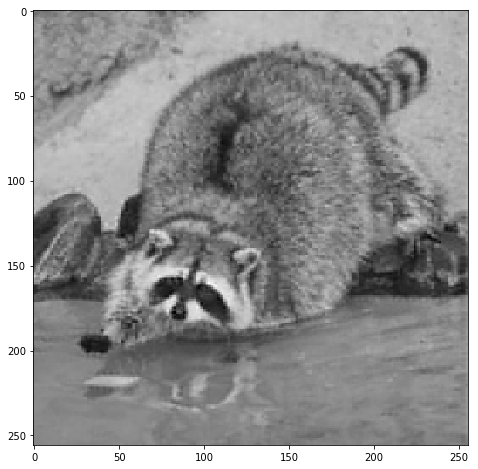

8


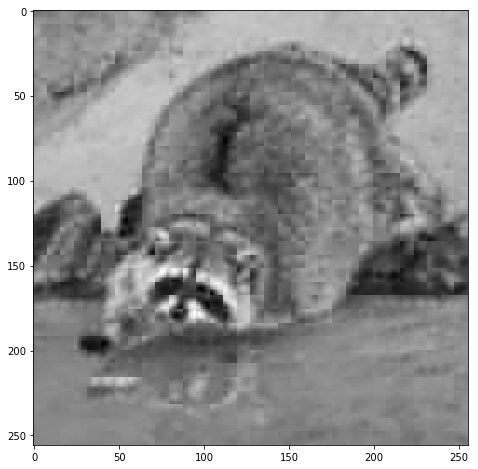

16


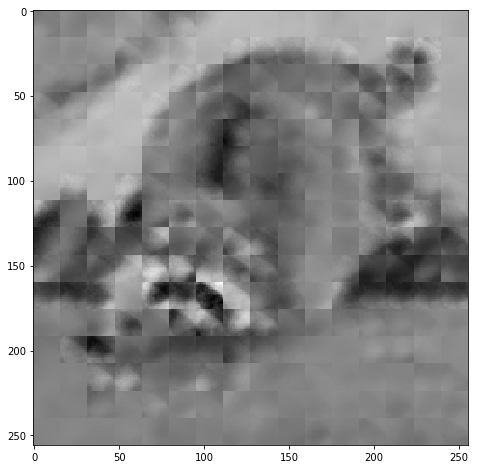

32


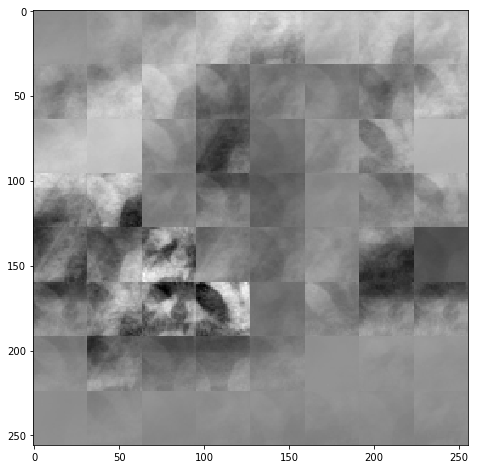

64


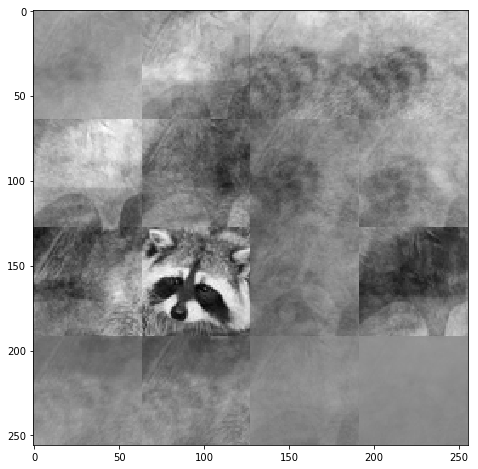

In [ ]:
for n in (4,8,16,32,64):
    d=5
    vec=r(img, n, strok, stolb)
    vectors=[]
    for i in range(len(vec)):
        vectors.append(vec[i].flatten())
    vectors=np.array(vectors)
    newvec, E, lka=pca(vectors, d)
    reconstr = np.dot(newvec,E)
    for i in range(len(reconstr)):
        reconstr[i]+=lka[i]
    reconstr2=[]
    for i in range(len(reconstr)):
        reconstr2.append(reconstr[i].reshape(n, n))
    reconstr2=np.array(reconstr2)
    reconstr2.shape
    reconstr3=rer2(reconstr2, n, strok, stolb)  
    print(n)
    plt.figure(figsize=(15,8))
    plt.imshow(reconstr3,cmap='gray')
    plt.show()

**Очевидно, что в данном эксперименте относительно приемлемое качество только для n=4,8. Далее качество изображения падает очень сильно.
Заметим при этом, что только на 4 изображение выглядит более или менее нормально, на 8 качество уже не такое хорошее.
Т.е. , я бы сказал, оптимальное n=4, в крайнем случае можно поставить 8.**


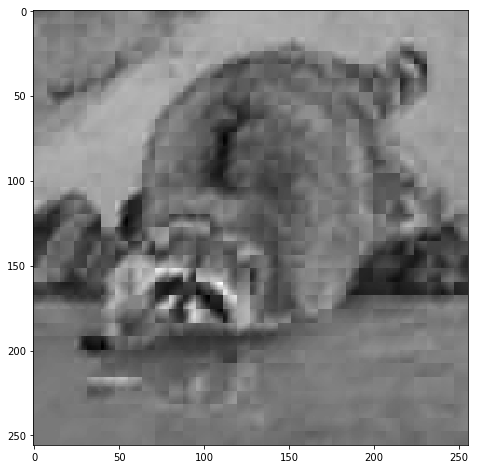

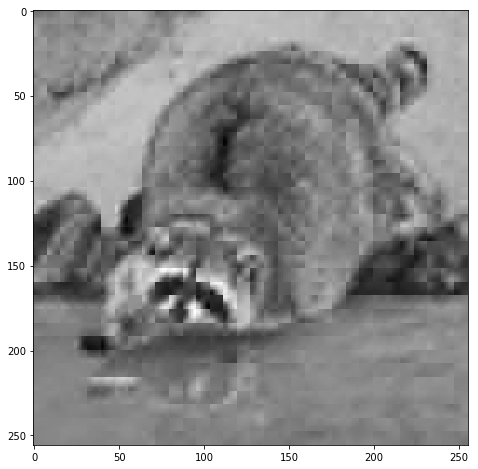

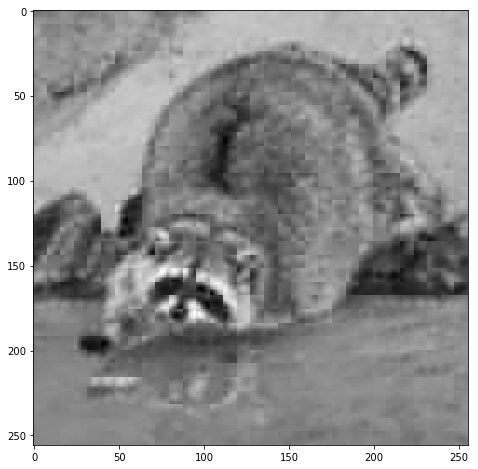

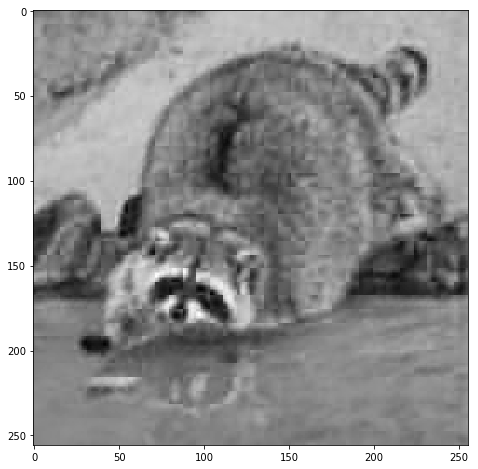

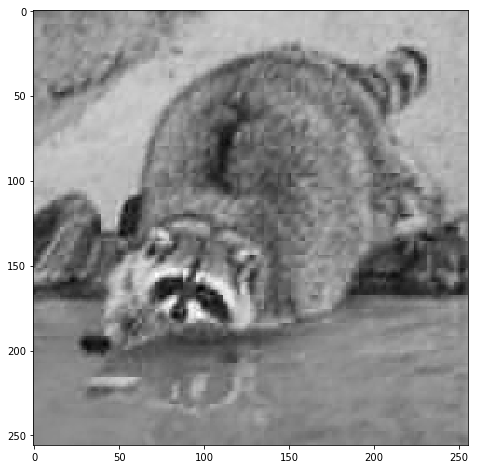

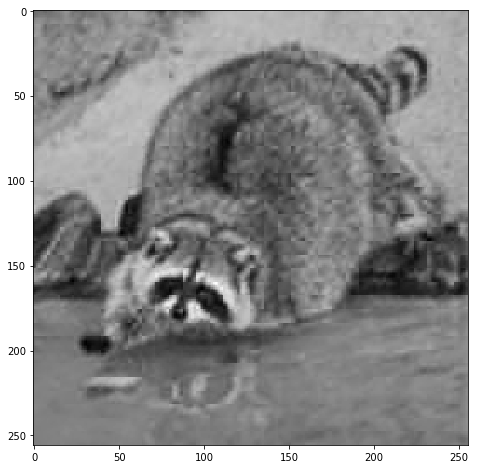

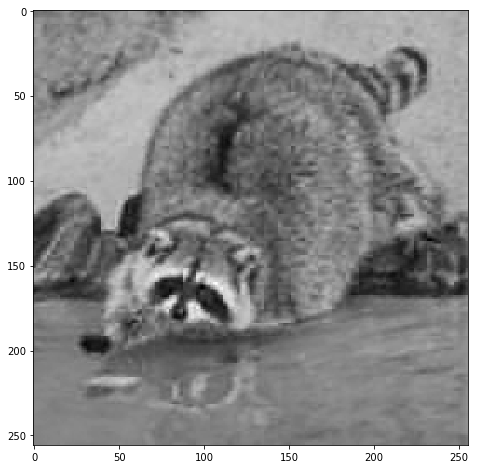

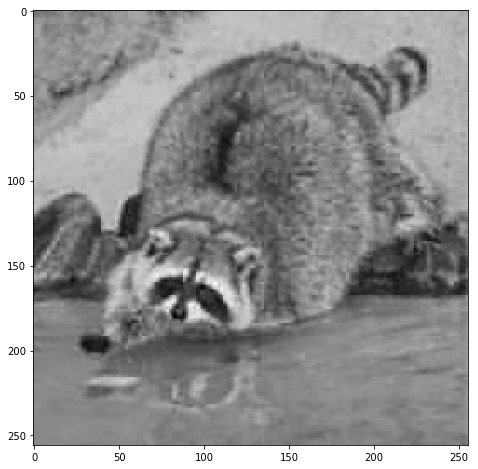

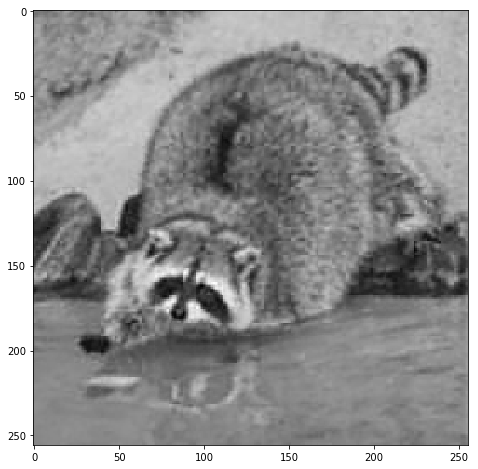

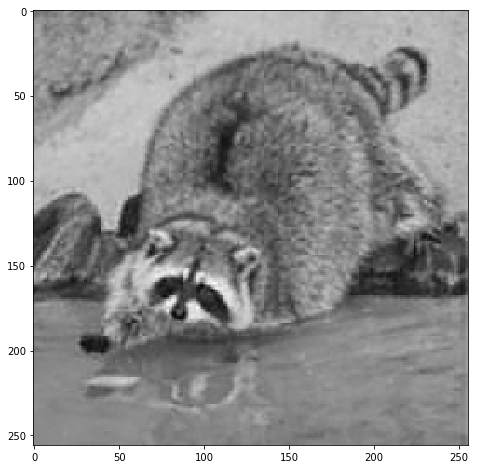

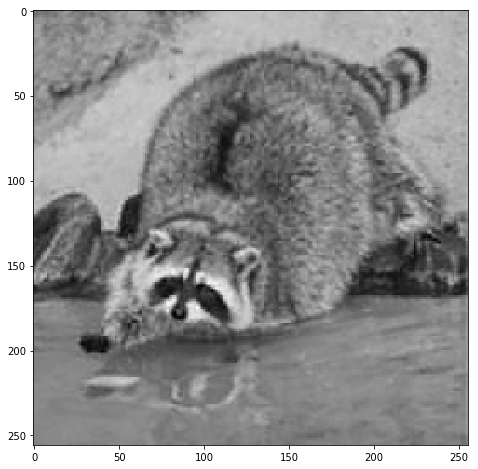

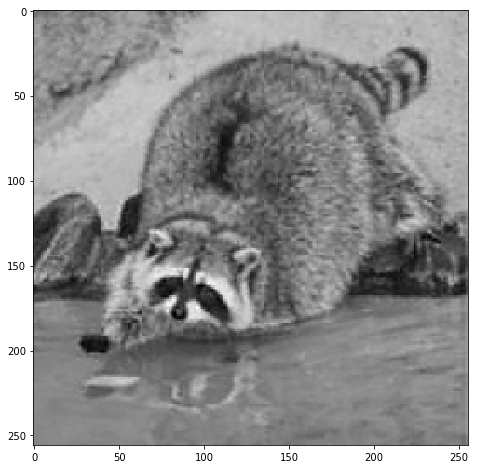

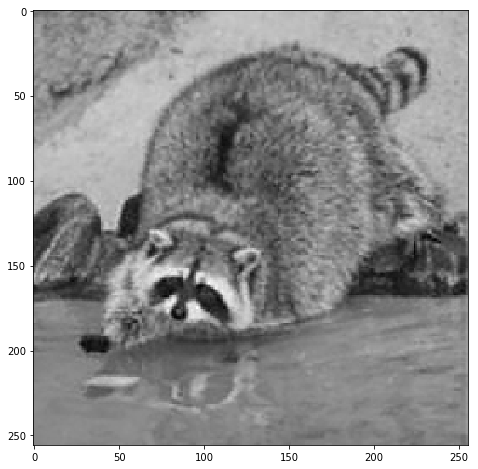

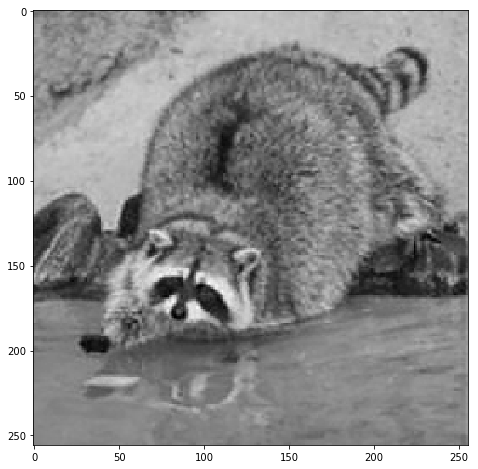

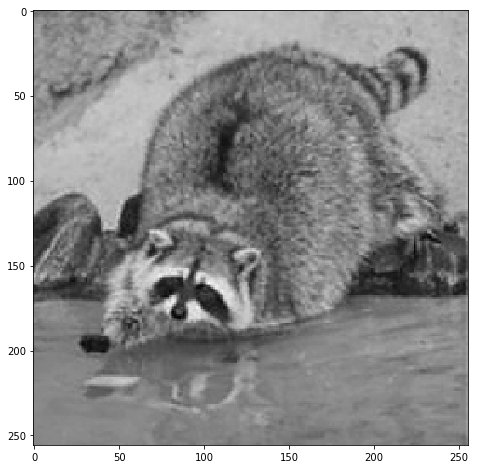

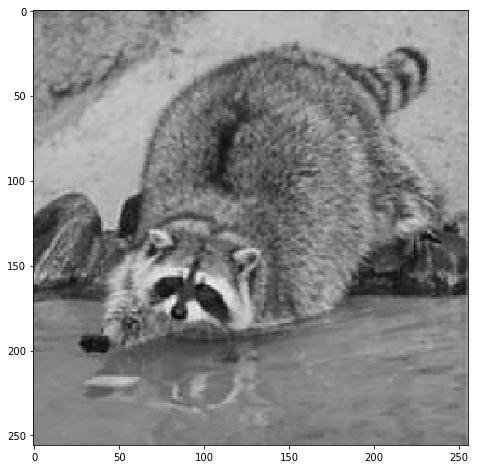

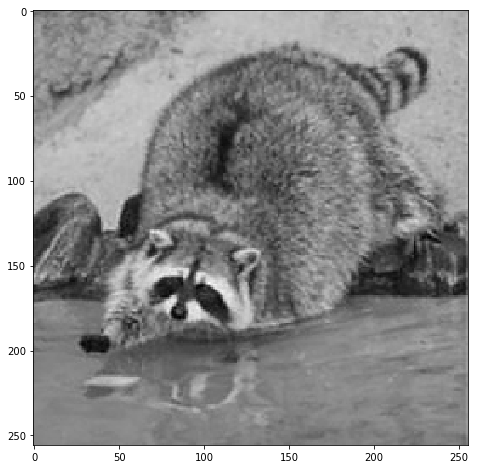

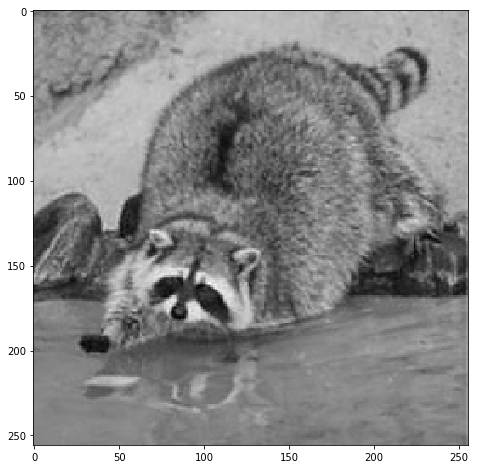

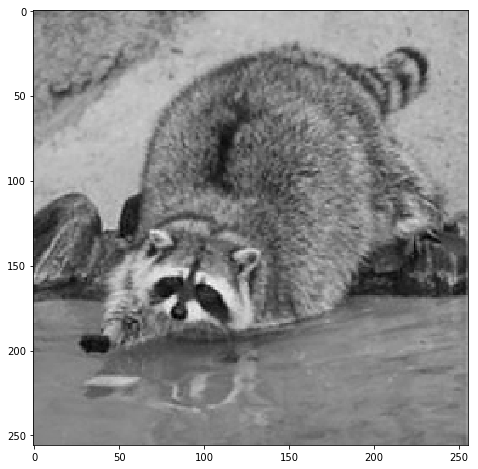

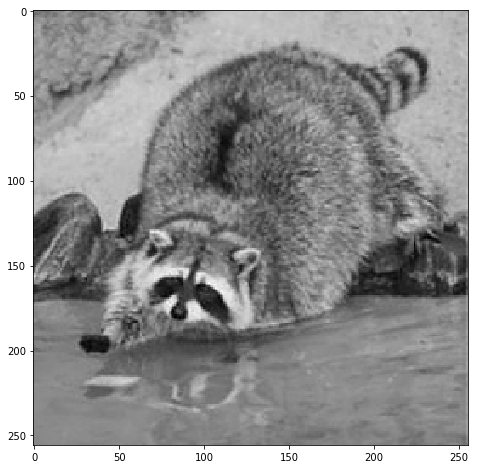

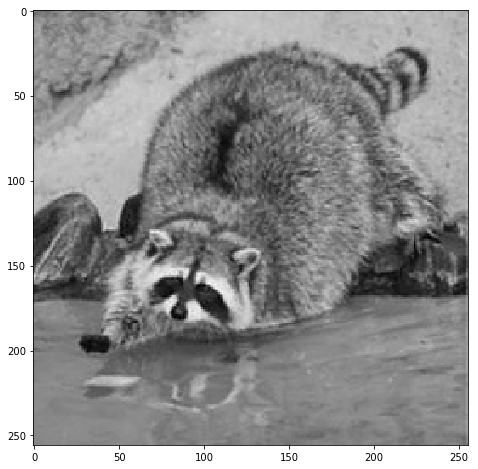

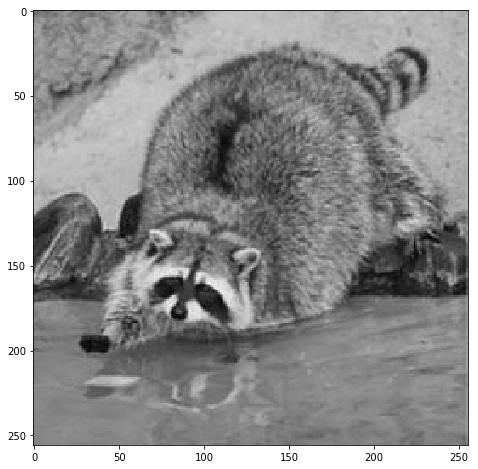

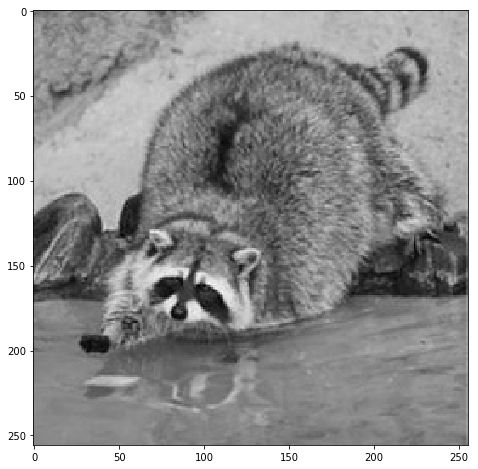

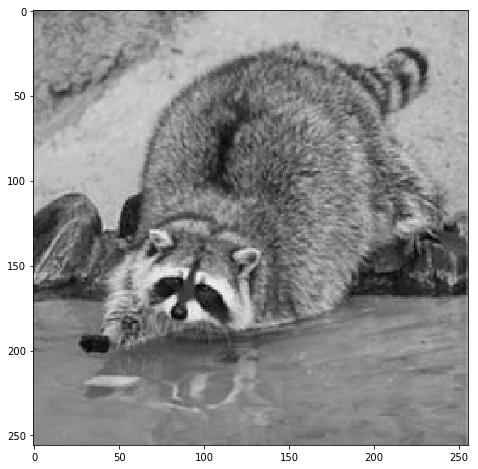

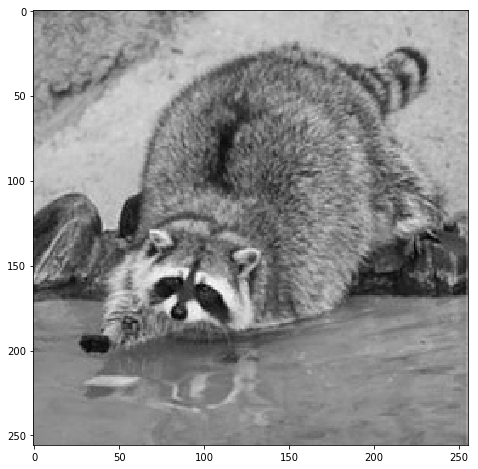

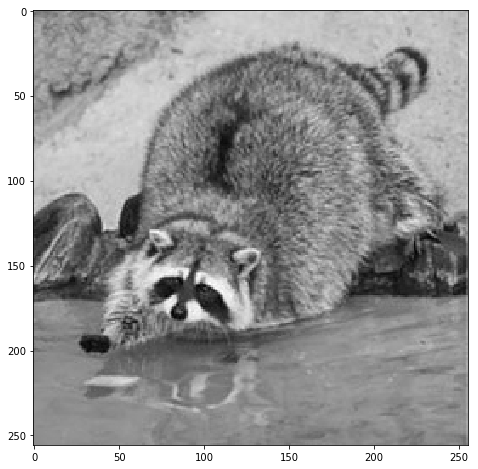

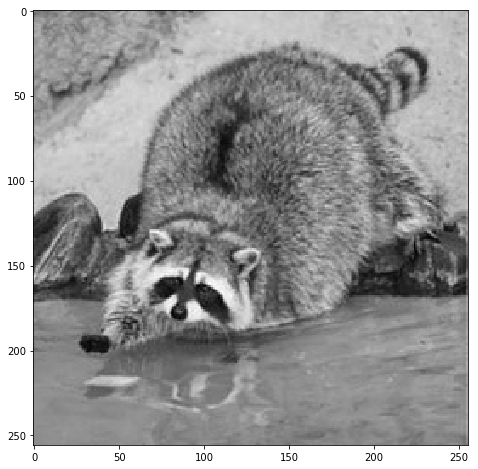

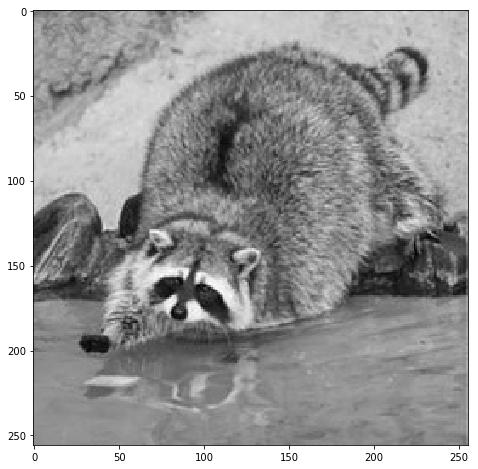

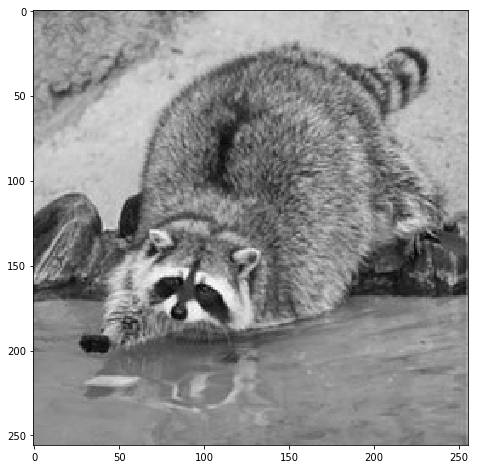

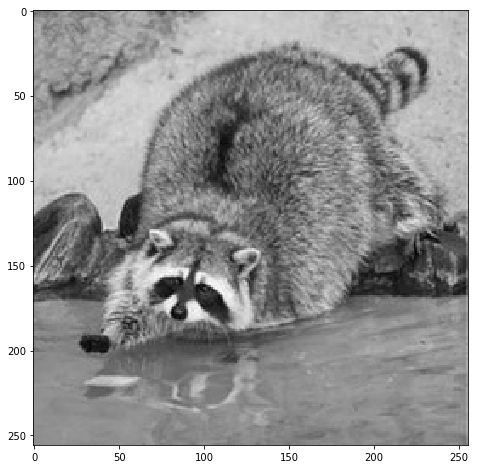

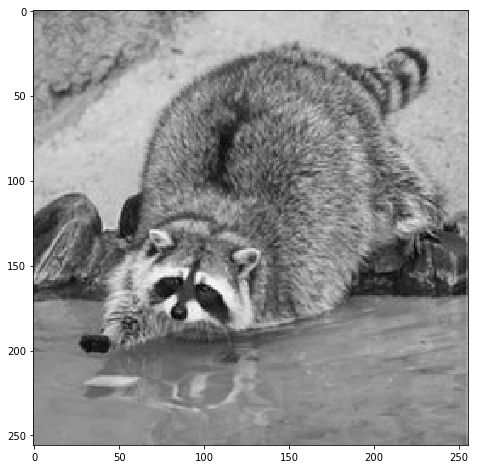

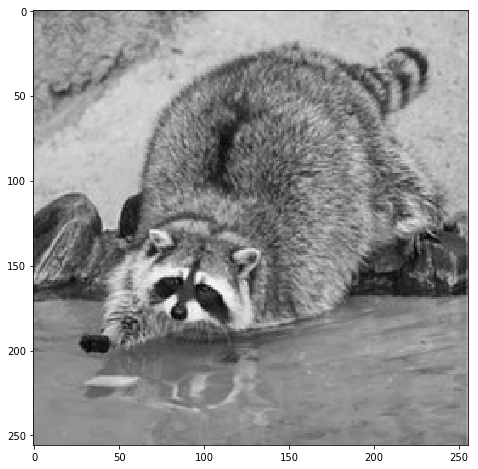

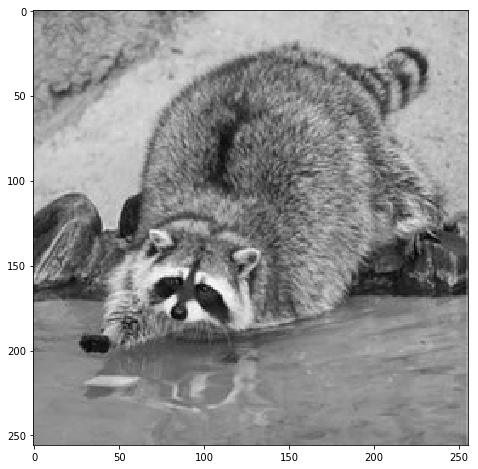

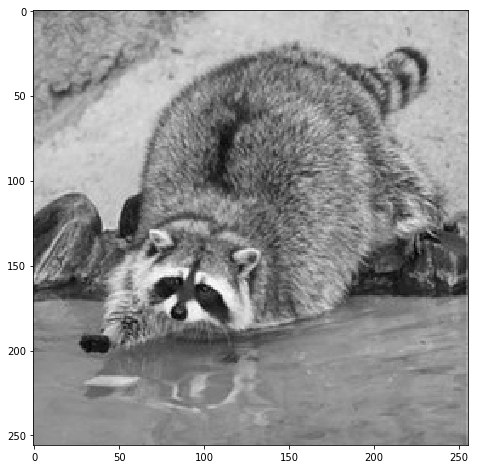

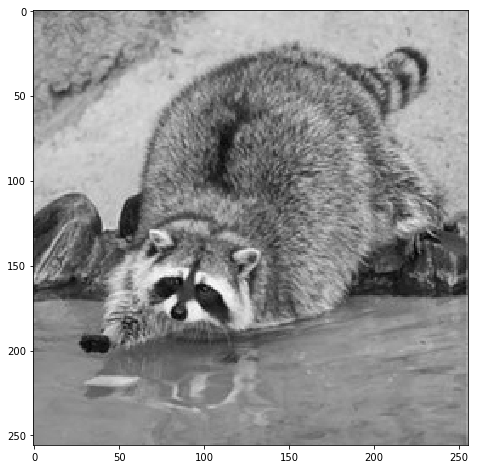

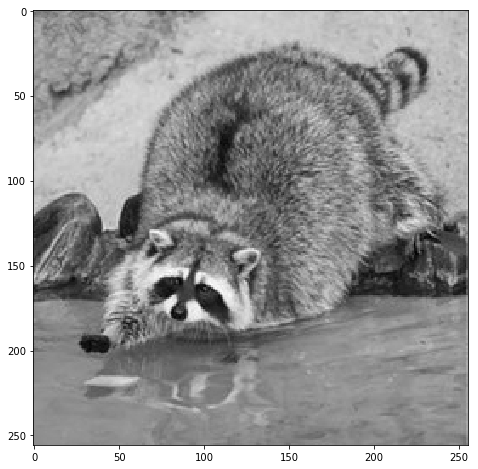

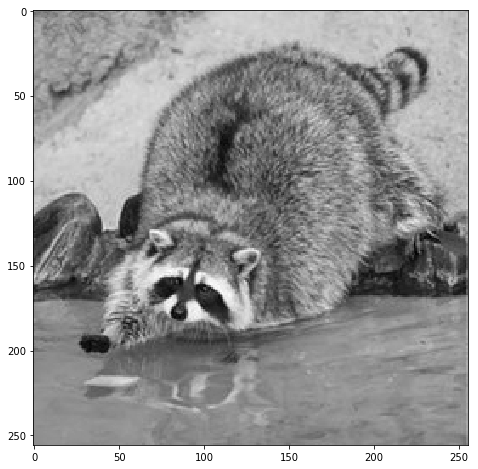

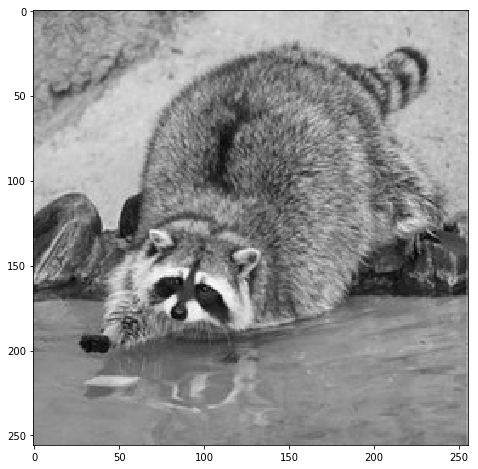

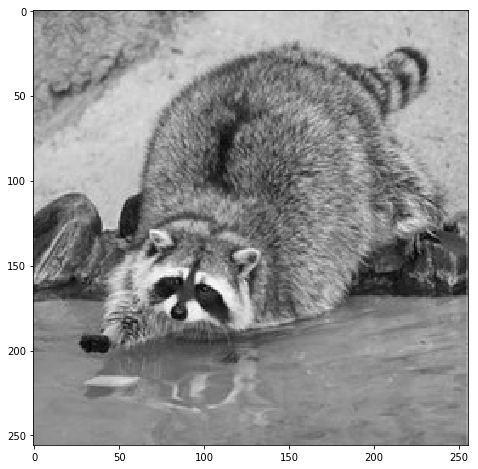

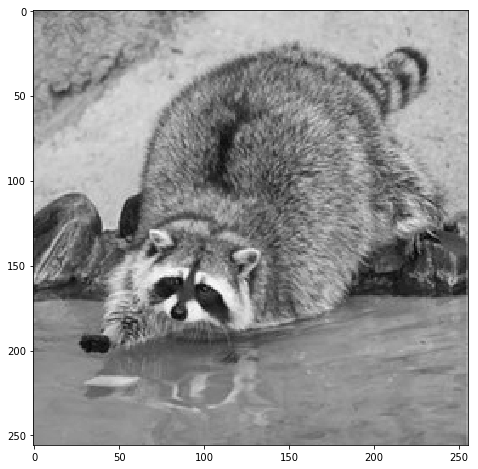

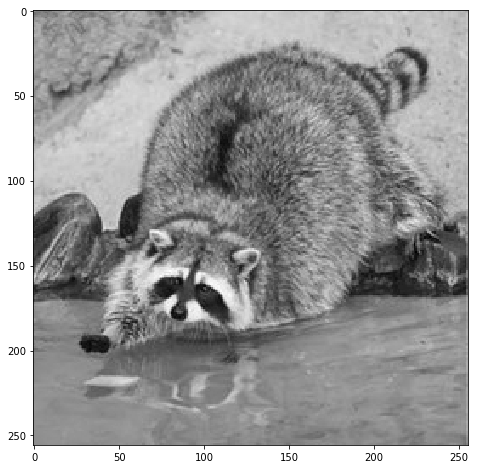

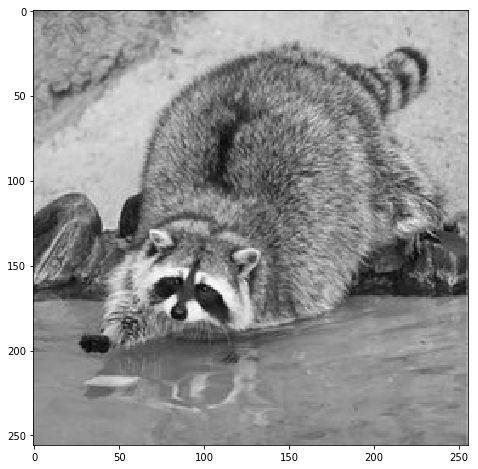

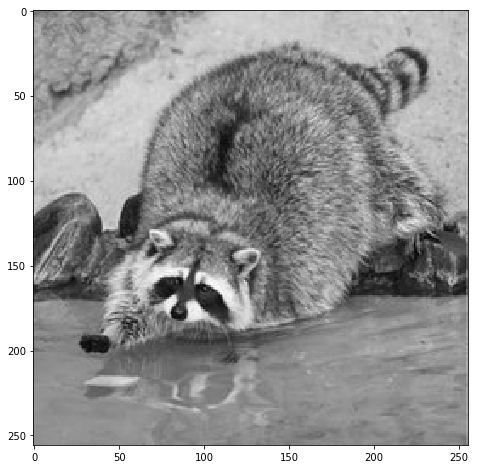

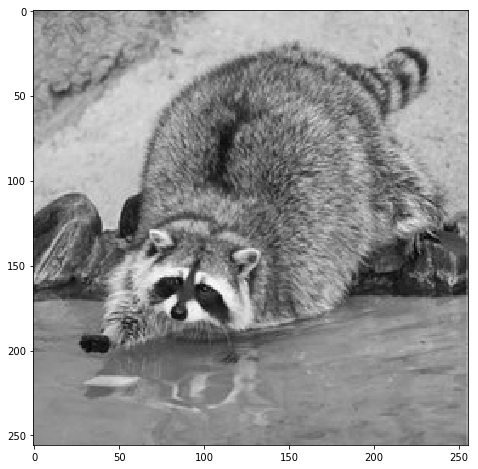

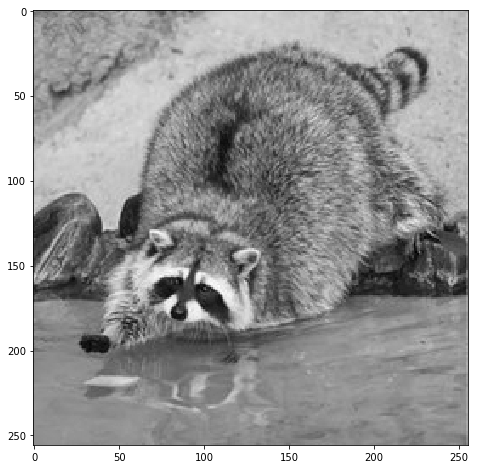

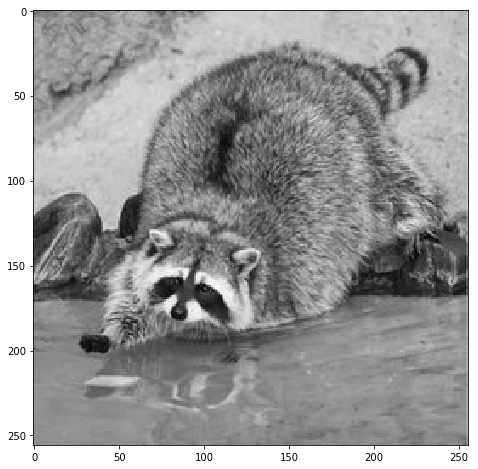

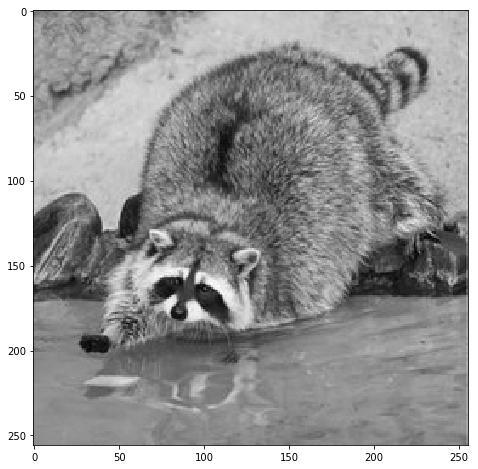

In [119]:
# То же самое для d
for d in range(3, 50):
    n=8
    vec=r(img, n, strok, stolb)
    vectors=[]
    for i in range(len(vec)):
        vectors.append(vec[i].flatten())
    vectors=np.array(vectors)
    newvec, E, lka=pca(vectors, d)
    reconstr = np.dot(newvec,E)
    for i in range(len(reconstr)):
        reconstr[i]+=lka[i]
    reconstr2=[]
    for i in range(len(reconstr)):
        reconstr2.append(reconstr[i].reshape(n, n))
    reconstr2=np.array(reconstr2)
    reconstr2.shape
    reconstr3=rer2(reconstr2, n, strok, stolb)  
    plt.figure(figsize=(15,8))
    plt.imshow(reconstr3,cmap='gray')
    plt.show()

**Видно, что для d>= 6 качество повышается очень медленно. Таким образом, оптимыльные n и d ~равны, соответственно, 4 и 6**

In [20]:
#Ex3. Comparing to jpeg

#  The jpeg module has been removed in Python 3. Хм, видимо, подразумевается устное какое-то сравнение? Я в питоне 2 не шарю.
**Если верить вот этой вот статеечке https://habrahabr.ru/post/206264/, в jpeg`е используются какие-то очень крутые штуки, типа там базисные
    векторы - это какие-то синусоиды или что-то в этом духе. Т.е. всё вычисляется с помощью математики.
    Причём, я так полагаю, в jpeg-e базис всегда 1. В pca же мы просто выбираем самый классный базис для данного изображения
    ( не общий для всех, а лучший для данного)**

In [21]:
#Ex4

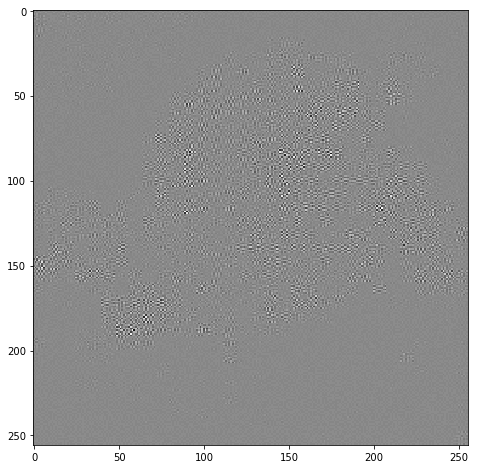

In [27]:
plt.figure(figsize=(15,8))
plt.imshow(reconstr3-img,cmap='gray')
plt.show()

**Как я понял, чёрный - без изменений, белый - очень изменился. Как видно, так или иначе подверглась имзенению вся картинка
( серые полутона), однако место предположительного нахождения енота ( а енот здесь - самый интересный и сложный элемент изображения )
подверглось сильным изменениям - местами цвета были изменены до неузнаваемости. Связано это, я думаю , с тем, что енот как бы немного пёстрый - 
рядышком находятся совсем разные цвета, в то же время фон относительно равномерный. Поэтому фон потерял немного в качестве ( почти и не потерял, раз уж он ближе к чёрному),
енотик же пострадал**